In [1]:
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
from hydra import compose, initialize
from hydra.utils import instantiate
import numpy as np
import pytorch_lightning as pl
import torch
from torch import Tensor
import torch.nn.functional as F
from einops import rearrange
from torch.utils.data import DataLoader, Dataset
import galsim
from bliss.catalog import TileCatalog, get_is_on_from_n_sources, FullCatalog
from bliss.datasets.background import ConstantBackground
from bliss.datasets.sdss import convert_flux_to_mag
from bliss.datasets.galsim_galaxies import GalsimBlends
from case_studies.coadds.signal_noise_ratio import get_snr
from case_studies.coadds.coadd_decoder import (
    CoaddUniformGalsimGalaxiesPrior,
    CoaddSingleGalaxyDecoder,
    CoaddGalsimBlends,
    FullCatalogDecoder,
)
from case_studies.coadds.align_single_exposures import align_single_exposures

In [5]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline

Modules to reload:
all-except-skipped

Modules to skip:



In [34]:
with initialize(config_path="../coadds/config"):
    cfg = compose("config", overrides=[])

In [35]:
prior = instantiate(cfg.datasets.sdss_galaxies_coadd.prior)
decoder = instantiate(cfg.datasets.sdss_galaxies_coadd.decoder)
background = instantiate(cfg.datasets.sdss_galaxies_coadd.background)

In [36]:
# check prior to get galaxy parameters
max_n_sources = 1
max_shift = 0.5
num_dithers = 4
sampled_cuggp = CoaddUniformGalsimGalaxiesPrior(
    prior, max_n_sources, max_shift, num_dithers
).sample(num_dithers)

In [37]:
pixel_scale = 0.393
n_sources = sampled_cuggp["n_sources"]
galaxy_params = sampled_cuggp["galaxy_params"]
locs = sampled_cuggp["locs"]
galaxy_bools = sampled_cuggp["galaxy_bools"]
star_bools = sampled_cuggp["star_bools"]
dithers = sampled_cuggp["dithers"]
offset = None

In [38]:
# check decoder to render galaxies
csgd = CoaddSingleGalaxyDecoder(
    decoder, decoder.n_bands, decoder.pixel_scale, "./data/sdss/psField-000094-1-0012-PSF-image.npy"
)
csgdgalaxy = csgd.render_galaxy(
    galaxy_params=galaxy_params[0],
    slen=decoder.slen,
    psf=decoder.psf,
    offset=offset,
    dithers=dithers,
)

/home/wmallory/bliss/case_studies/coadds/coadd_decoder.py:154: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))


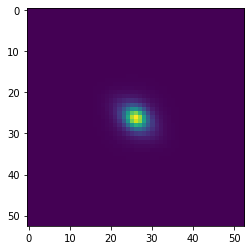

In [39]:
plt.imshow(csgdgalaxy[0].reshape(csgdgalaxy[0].shape[1], csgdgalaxy[0].shape[2]).numpy())

In [40]:
# check FullCatalogDecoder
prior = instantiate(cfg.datasets.galsim_blended_galaxies_coadd.prior)
decoder = instantiate(cfg.datasets.galsim_blended_galaxies_coadd.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies_coadd.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 1000
n_batches = 1
full_catalog = CoaddGalsimBlends(
    prior=prior,
    decoder=decoder,
    background=background,
    tile_slen=tile_slen,
    max_sources_per_tile=max_tile_n_sources,
    num_workers=num_workers,
    batch_size=batch_size,
    n_batches=n_batches,
)._sample_full_catalog()

In [46]:
slen = 40
bp = 24
fcdecoder = FullCatalogDecoder(decoder, slen, bp, dithers)

In [49]:
image, noiseless_centered, noiseless_uncentered, image0 = decoder.render_catalog(
    full_catalog, decoder.single_decoder.psf, dithers
)

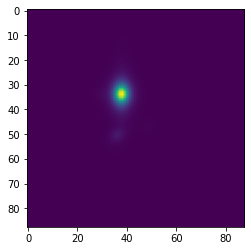

In [50]:
plt.imshow(image0[0].reshape(image0[0].shape[1], image0[0].shape[2]).numpy())

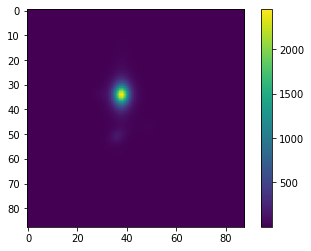

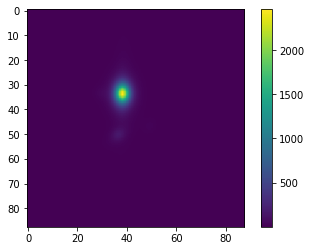

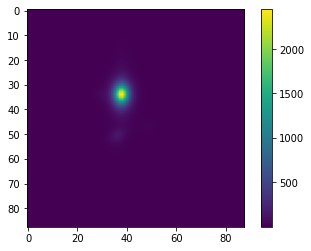

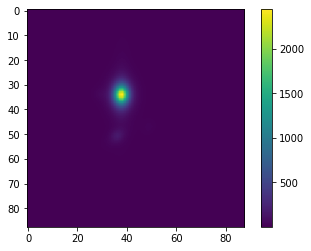

In [51]:
for i in range(image.shape[0]):
    plt.figure()
    plt.imshow(image[i].reshape(image[i].shape[1], image[i].shape[2]).numpy())
    plt.colorbar()

In [52]:
(
    noiseless,
    noiseless_centered,
    noiseless_uncentered,
    background,
    snr_images,
    coadded_image,
) = CoaddGalsimBlends(
    prior=prior,
    decoder=decoder,
    background=background,
    tile_slen=tile_slen,
    max_sources_per_tile=max_tile_n_sources,
    num_workers=num_workers,
    batch_size=batch_size,
    n_batches=n_batches,
)._get_images(
    full_catalog, dithers
)

/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [grid, torch.stack((torch.tensor(x_grid), torch.tensor(y_grid)), -1)], dim=0
/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(images[:]).reshape(len(dithers), 1, slen, slen).float()
/home/wmallory/bliss/case_studies/coadds/align_single_exposures.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interped_images = torch.tensor(interped

In [53]:
coadded_image.shape

torch.Size([1, 86, 86])

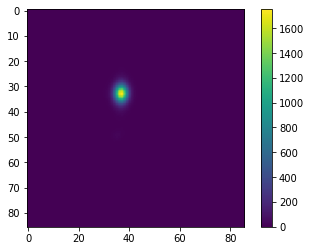

In [54]:
for i in range(coadded_image.shape[0]):
    plt.figure()
    plt.imshow(coadded_image[i].reshape(coadded_image.shape[1], coadded_image.shape[2]).numpy())
    plt.colorbar()